<a href="https://colab.research.google.com/github/Satwikram/HuggingFace/blob/main/Fine-tuning%20a%20masked%20language%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Setup

In [ ]:
!pip install transformers datasets

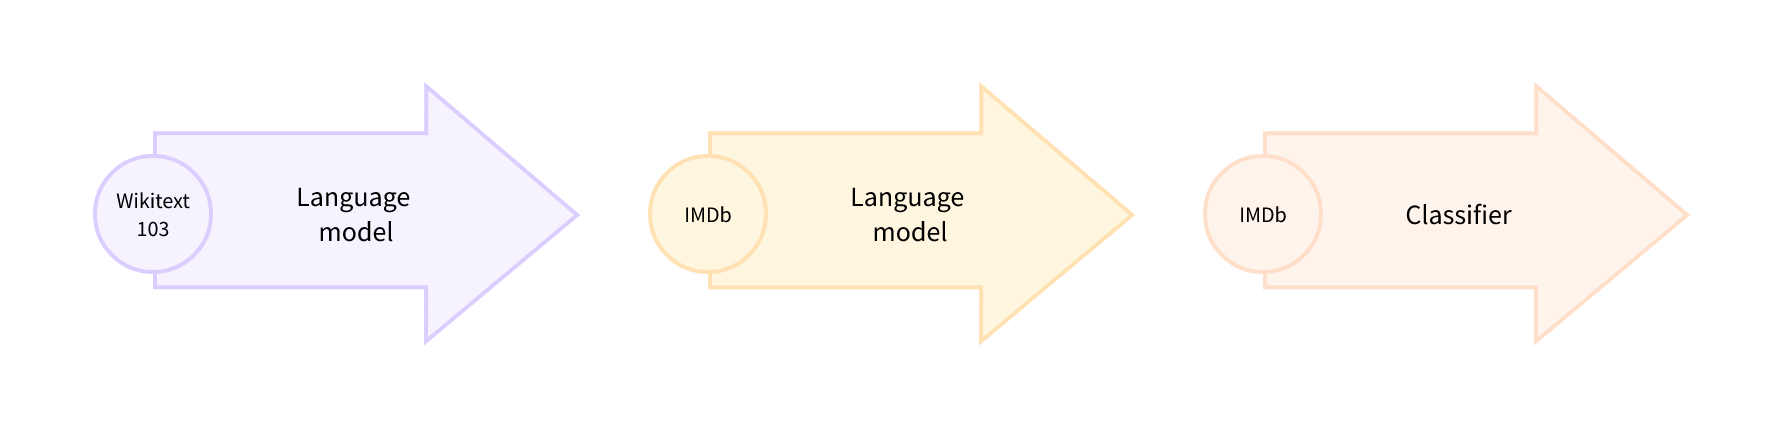

### Importing Dependencies

In [1]:
from transformers import TFAutoModelForMaskedLM, AutoTokenizer
import numpy as np
import tensorflow as tf

### Initializing the model

In [2]:
model_checkpoint = "distilbert-base-uncased"
model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForMaskedLM: ['activation_13']
- This IS expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


In [3]:
model.summary()

Model: "tf_distil_bert_for_masked_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 vocab_transform (Dense)     multiple                  590592    
                                                                 
 vocab_layer_norm (LayerNorm  multiple                 1536      
 alization)                                                      
                                                                 
 vocab_projector (TFDistilBe  multiple                 23866170  
 rtLMHead)                                                       
                                                                 
Total params: 66,985,530
Trainable params: 66,985,530
Non-trainable params: 0
__________________________

In [4]:
text = "This is a great [MASK]."

### Tokenization

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

With a tokenizer and a model, we can now pass our text example to the model, extract the logits, and print out the top 5 candidates:

In [6]:
inputs = tokenizer(text, return_tensors="np")

In [7]:
inputs

{'input_ids': array([[ 101, 2023, 2003, 1037, 2307,  103, 1012,  102]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [8]:
token_logits = model(**inputs).logits

In [9]:
token_logits

<tf.Tensor: shape=(1, 8, 30522), dtype=float32, numpy=
array([[[ -5.588161 ,  -5.5868373,  -5.5958486, ...,  -4.9447727,
          -4.8174024,  -2.9905226],
        [-11.90314  , -11.887163 , -12.062249 , ..., -10.95697  ,
         -10.646375 ,  -8.632356 ],
        [-11.960378 , -12.152035 , -12.127866 , ..., -10.021761 ,
          -8.607408 ,  -8.097103 ],
        ...,
        [ -4.8227916,  -4.6267867,  -5.104059 , ...,  -4.2771416,
          -5.018431 ,  -3.9427614],
        [-11.294456 , -11.23876  , -11.385687 , ...,  -9.206297 ,
          -9.341139 ,  -6.1504908],
        [ -9.521323 ,  -9.4632225,  -9.502177 , ...,  -8.6560955,
          -8.490813 ,  -4.6902914]]], dtype=float32)>

In [10]:
inputs["input_ids"]

array([[ 101, 2023, 2003, 1037, 2307,  103, 1012,  102]])

In [11]:
tokenizer.mask_token_id

103

In [12]:
np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]

5

In [21]:
# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
mask_token_logits = token_logits[0, mask_token_index, :]

In [24]:
mask_token_logits

<tf.Tensor: shape=(30522,), dtype=float32, numpy=
array([-4.8227916, -4.6267867, -5.104059 , ..., -4.2771416, -5.018431 ,
       -3.9427614], dtype=float32)>

In [25]:
# Pick the [MASK] candidates with the highest logits
# We negate the array before argsort to get the largest, not the smallest, logits
top_5_tokens = np.argsort(-mask_token_logits)[:5].tolist()

for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

>>> This is a great deal.
>>> This is a great success.
>>> This is a great adventure.
>>> This is a great idea.
>>> This is a great feat.


In [13]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [14]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'
'>>> Label: 1'

'>>> Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stu

### Preprocessing the data

In [16]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

In [17]:
chunk_size = 128

In [18]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


In [19]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 800'


In [20]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 32'


In [21]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])